# Credit Card Default Predictions & Risk Management
Author: Tom Cooper

**Problem Type:** Supervised Learning - Imbalanced Binary Classification 

Data analytics and predictive modeling have become increasingly important in lending and finance. Many corporations around the world have looked to machine learning on big data to better understand their businesses and customers with improving results. In this notebook, we will analyze Taiwanese credit card default data from the UCI Machine Learning Repository to understand how to mitigate credit card defaults. 

**Agenda:**
- **Exploratory Data Analysis:** Identify features most correlated with credit card defaults
- **Predictive Modeling with XGBoost:** Predict customer defaults using XGBoost machine learning algorithm
- **Active Risk Management:** Gains / Lift Tables: Assess Gains / Lift tables for active risk-management initiatives
- **Summary**
    
**Attribute Information:**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 


**XGBoost Classifier Model Performance:**
- Accuracy: 82%
- Test AUC: 80%


**Active Risk-Management Summary:**
- Using Gains / Lift tables based on the XGBoost Classifier Model, we find that we could capture ~75% of high-risk customers for credit modification by targeting only 40% of clients, optimizing the cost-per-default-prevention-ratio.  

Note: Default of payment next month = 1 is synonymous with defaults and high-risk clients in this notebook

**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
from xgboost import XGBClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import nbconvert
%matplotlib inline

# Exploratory Data Analysis

**Read in CSV File**

In [3]:
df = pd.read_csv('Default of credit card clients.csv')
#LIMIT_BAL of NT$1,000,000, BILL_AMT1 greater than NT$700,000 and BILL_AMT1 less than -NT$1,000 are outliers. Removed for better clarity
df = df[(df['LIMIT_BAL']<1000000) & (df['BILL_AMT1']>-100000) & (df['PAY_0']<6) & (df['BILL_AMT1']<700001) & (df['BILL_AMT2']<700001)]
#Drop ID Column
df.drop('ID',axis=1,inplace=True)

**Check head of DataFrame for structure**

In [49]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Check DataFrame info for row and column entries as well as data types**

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29956 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     29956 non-null int64
SEX                           29956 non-null int64
EDUCATION                     29956 non-null int64
MARRIAGE                      29956 non-null int64
AGE                           29956 non-null int64
PAY_0                         29956 non-null int64
PAY_2                         29956 non-null int64
PAY_3                         29956 non-null int64
PAY_4                         29956 non-null int64
PAY_5                         29956 non-null int64
PAY_6                         29956 non-null int64
BILL_AMT1                     29956 non-null int64
BILL_AMT2                     29956 non-null int64
BILL_AMT3                     29956 non-null int64
BILL_AMT4                     29956 non-null int64
BILL_AMT5                     29956 non-null int64
BILL_AMT6                     29956 non-null int64
PAY_AMT1                

In [6]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000,...,29956.000000,29956.000000,29956.000000,29956.000000,2.995600e+04,29956.000000,29956.000000,29956.000000,29956.000000,29956.000000
mean,167492.979036,1.603919,1.852851,1.551976,35.482241,-0.026172,-0.141975,-0.173287,-0.226465,-0.270797,...,43137.369408,40187.041227,38754.243758,5644.541694,5.920239e+03,5202.487415,4830.173254,4795.781613,5216.945587,0.220724
std,129621.988953,0.489090,0.790559,0.521994,9.217047,1.093516,1.175576,1.181472,1.158506,1.126564,...,64002.277933,60432.360814,59169.706937,16269.353483,2.302837e+04,16850.277641,15674.215620,15260.814999,17786.342038,0.414741
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2314.750000,1759.000000,1249.500000,1000.000000,8.500000e+02,390.000000,300.000000,258.750000,122.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19012.500000,18072.500000,17014.500000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54364.250000,50092.000000,49107.000000,5007.000000,5.000000e+03,4512.000000,4015.250000,4037.000000,4000.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,5.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,823540.000000,699944.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


**Imbalanced Data**

Let's get a sense for how balanced or imbalanced is the target variable (default payment next month). From the chart below, we see that Good Clients outnumber Bad Clients by approximately 5x. Working on imbalanced datasets can be problematic, as simple classification algorithms tend to struggle in such situations.

In [795]:
def add_freq():
    ncount = len(df)
    ax2=ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

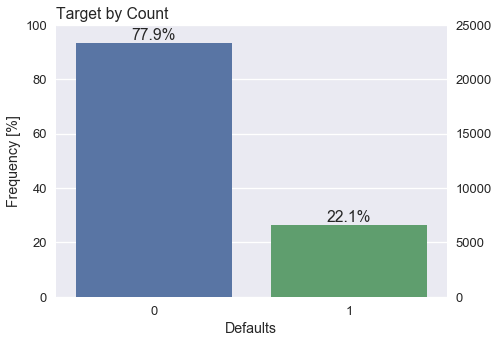

In [897]:
plt.title('Target by Count', loc='left')
ax = sns.countplot(data=df,x='default payment next month')
ax.set_xlabel('Defaults')
ax.set_ylabel(' ')
fig = plt.gcf()
ax.set_ylim(top=25000)
fig.set_size_inches(7,5)
add_freq()
plt.show()
sns.set_context('talk')

**Dataset Correlations**

**Strongest Correlations to Defaults**

- **Payment Record:** Strong Positive Relationship. Correlation with default is higher the further behind a client is during the payment closest to the month of default 

- **Limit Balance:** Strong Negative Relationship. Clients with lower limits tend to have a higher correlation with defaults than those with higher limits

Let's take a look at these in further detail.

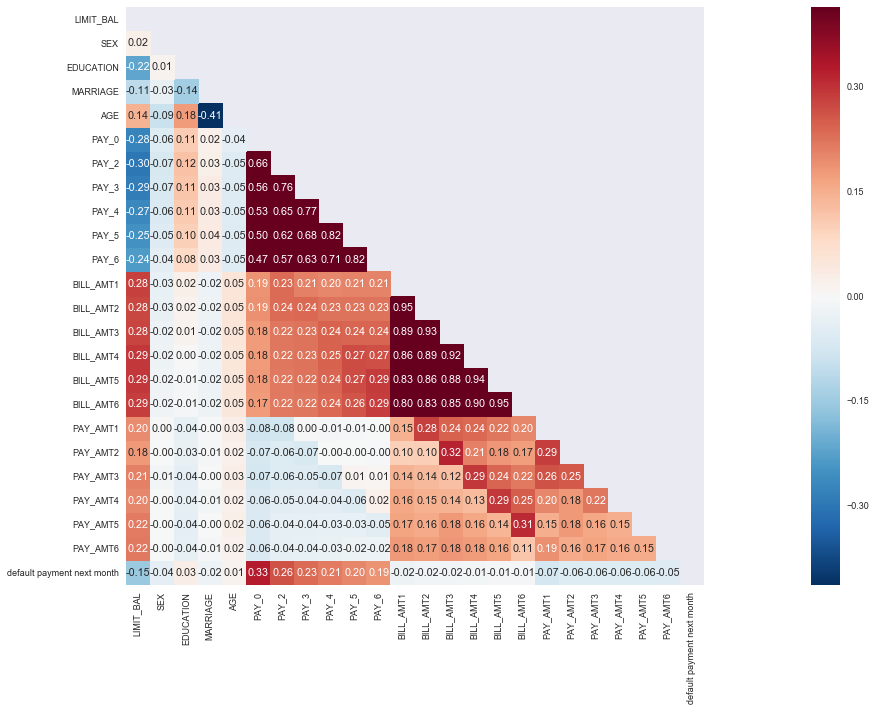

In [1039]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(30,10))
    ax = sns.heatmap(df.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".2f")
    sns.set(font_scale=.9) 
plt.tight_layout() 

**Limit Balance vs Credit Behavior**
- 93% of client account limits are less than NT$400,000
- While most clients in the dataset do not default, clients with lower credit limits tend to default at higher rates

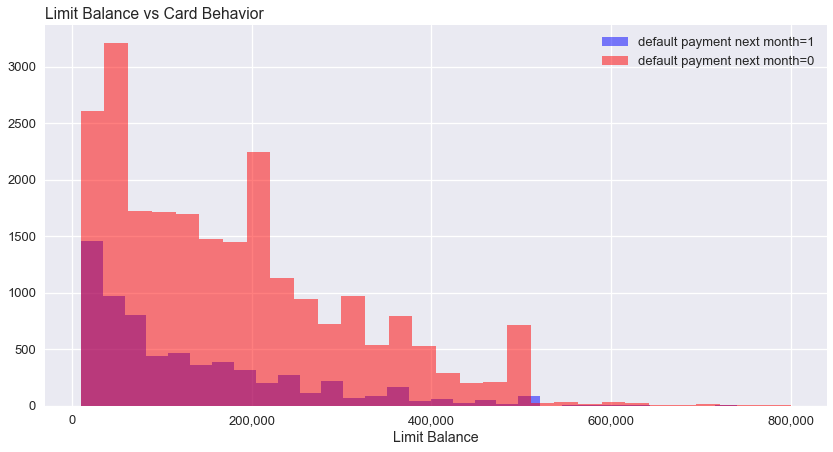

In [6]:
plt.figure(figsize=(14,7))
df[df['default payment next month']==1]['LIMIT_BAL'].hist(alpha=0.5,color='blue', bins=30,label='default payment next month=1')
df[df['default payment next month']==0]['LIMIT_BAL'].hist(alpha=0.5,color='red', bins=30,label='default payment next month=0')
plt.title('Limit Balance vs Card Behavior',loc='left')
plt.xlabel('Limit Balance')
plt.xticks([0, 200000, 400000, 600000,800000],['0','200,000','400,000','600,000','800,000'])
plt.legend()
sns.set_context('talk')

**Age vs Credit Behavior**
- Default rates are slightly higher for clients under 25 and those over 60, which seems logical as income levels tend to be lower for these groups

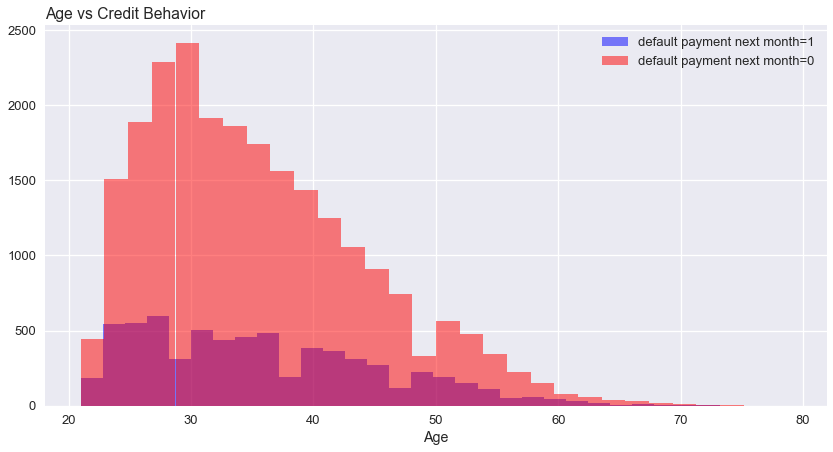

In [7]:
plt.figure(figsize=(14,7))
df[df['default payment next month']==1]['AGE'].hist(alpha=0.5,color='blue', bins=30,label='default payment next month=1')
df[df['default payment next month']==0]['AGE'].hist(alpha=0.5,color='red', bins=30,label='default payment next month=0')
plt.title('Age vs Credit Behavior',loc='left')
plt.legend()
plt.xlabel('Age')
sns.set_context('talk')

**Most Recent Payment Month (Arrears Category) vs Credit Behavior**
- Clients that are one to four months behind during current payment month default at much higher rates

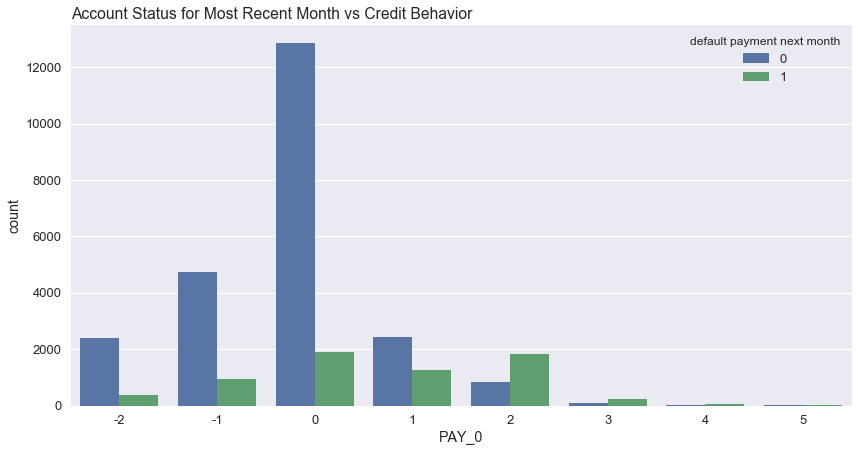

In [35]:
plt.figure(figsize=(14,7))
sns.countplot(data=df,x='PAY_0',hue='default payment next month')
plt.title('Account Status for Most Recent Month vs Credit Behavior',loc='left')
sns.set_context('talk')

**Credit Card Behavior**
- Clients with Bill Amounts that are a greater percentage of their Limit Balance default at moderately higher rates

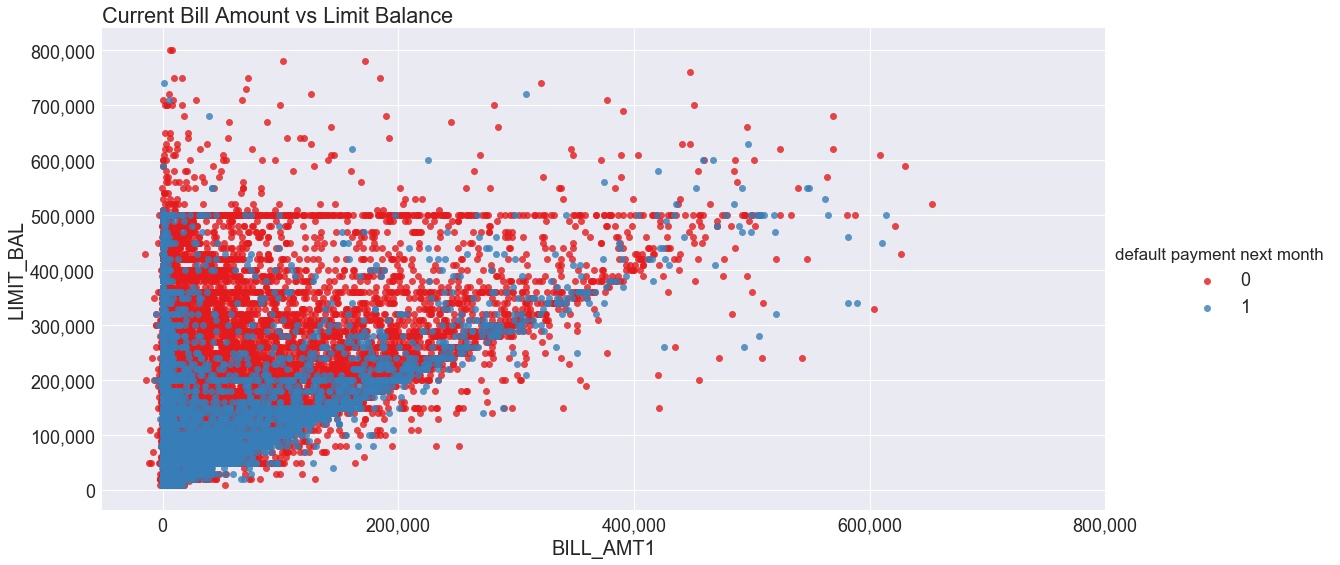

In [5]:
sns.lmplot(x='BILL_AMT1',y='LIMIT_BAL',data=df, hue='default payment next month',palette='Set1',size=8,aspect=2,fit_reg=False)
plt.xticks([0, 200000, 400000, 600000,800000],['0','200,000','400,000','600,000','800,000'])
plt.yticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000],['0', '100,000', '200,000', '300,000','400,000', '500,000','600,000', '700,000', '800,000'])
plt.title('Current Bill Amount vs Limit Balance', loc='left')
sns.set(font_scale=1.8)

**Final Data for Algorithm**

In [40]:
final_data = df

In [41]:
final_data = final_data.drop(['BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],axis=1)

In [42]:
#Set index as identifier
final_data['ID'] = final_data.index

In [43]:
#Adjusting 'default payment next month' to last column
pop = pd.DataFrame(final_data.pop('default payment next month'))
#Joined Target to train last column 
final_data = final_data.join(pop)

** Train Test Split**

Let's split the dataset into training and testing data. We will train our model on the training data and test its accuracy on the testing data.

In [44]:
#80% training data; 20% testing data
train = final_data.sample(frac=0.8,random_state=101)
test = final_data.drop(train.index)

#Test Results CSV File
test_known_y = test[['ID','default payment next month']]
test_known_y.to_csv('test_results.csv',index=False)

In [45]:
target = 'default payment next month'
IDcol = 'ID'

# XGBoost Classifier Model

XGBoost Classifier Model is an extreme gradient boosting machine learning algorithm, which uses gradient descent to minimize loss when adding new models. It essentially creates a number of models each one learning from the residuals or prediction errors of prior models. In context with an imbalanced class, this algorithm is better suited to handle such datasets.  

**XGBoost Classifier Model Fit***

In [46]:
test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['default payment next month'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['default payment next month'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['default payment next month'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['Predictions'] = alg.predict(dtest[predictors])
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print('AUC Score (Test): %f' % metrics.roc_auc_score(results['default payment next month'], results['predprob']))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(14,7))
    feat_imp.plot(kind='bar')
    plt.title('Feature Importance', loc='left')
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance Score')

**XGBoost Classifier Model Predictions and Performance**

Most classification algorithms are partial to the majority class and will misclassify the minority class in pursuit of accuracy, a common evaluation metric used for binary classification models.  We see that the majority class has a proportion of 77.9%. In other words, with a decent ML algorithm, our model would get 77.9% model accuracy. Although this performance seems gratifying on the surface, we actually want our evaluation metric to measure how well our model can distinguish high-risk clients from those who are not.   

**Area Under the Curve (AUC)**

AUC is a measure of true positive rate and false positive rate. Therefore, we should aim to reduce the threshold so that the false positive rate can be reduced. The accuracy of the test depends on how well the test separates the group being tested into high-risk and low-risk clients. Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless test. 

We will plot the ROC curve below to get a better understanding of the metric.

**Performance:** Our model AUC score of 80% is indicative of good performance. This performance indicates that our model does a good job of separating non-defaults and defaults.

**Feature Importance** 

From the plot below, we can see the features which are most important to determining high-risk clients in the model. Please note that we should interpret this measure in the following way: when all the features we have below are included in the model, Bill Amount for the most recent month is the most important feature in determining defaults.  


Model Report
Accuracy : 0.8231
AUC Score (Train): 0.800499
AUC Score (Test): 0.796309


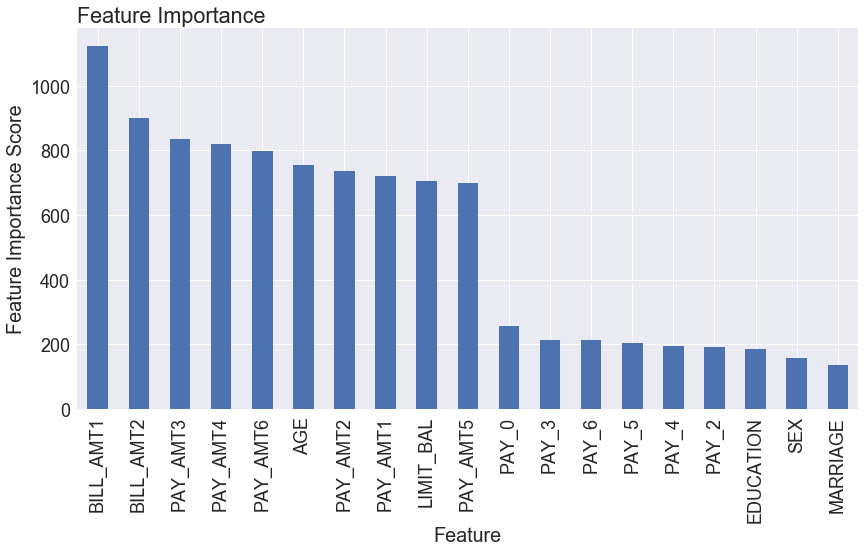

In [48]:
predictors = [x for x in train.columns if x not in [target, IDcol]]

xgb1 = XGBClassifier(base_score=0.50, colsample_bylevel=1, colsample_bytree=.59, gamma=0, learning_rate=0.01, 
                     max_delta_step=0, max_depth=6, min_child_weight=1, missing=None, n_estimators=20000, nthread=4, 
                     objective='binary:logistic', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=101, 
                     silent=True, subsample=.08)

modelfit(xgb1, train, test, predictors)

**ROC curve Plot****

Let's plot the ROC Curve below.

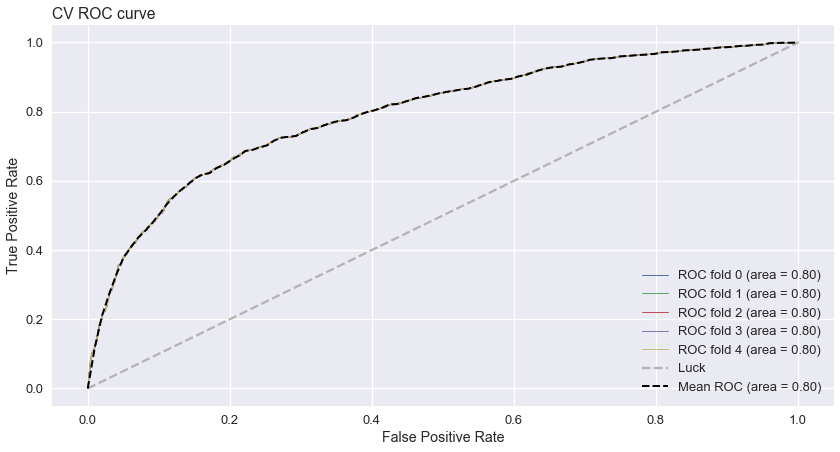

In [888]:
X_train = train.drop(['ID','default payment next month'],axis=1)
X_test = test.drop(['ID','default payment next month'],axis=1)
y_train = train['default payment next month']
y_test = test['default payment next month']

cv = StratifiedKFold(y_test, n_folds=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = xgb1.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.7, 0.7, 0.7), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CV ROC curve',loc='left')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(14,7)

# Active Risk Management: Gains / Lift Tables

**Overview**

The average default rate for customers in the dataset is 22.1%, which is considerably high by any standard. By actively monitoring these high-risk clients for potential modification initiatives, we could potentially avoid some defaults and save money. 

**Use of Gains / Lift Tables**

Targeting high-risks clients for modification is undoubtedly a sensible loss mitigation technique.  However, targeting high-risk clients one by one or at random is way too expensive on a cost-per-default-prevention-ratio basis. By using Gain / Lift tables based on a proficient model, we can target clients with the highest probability of default, optimizing the cost-per-default-prevention. 

**Default Probabilities and Gain / Lift Tables**

Using the XGBoost Classifier Model, we can create gains / lift tables to help us effectively target high-risk loans for modification. 
- Calculate probability of default (default payment next month = 1) for each client 
- Sort the probabilities for each loan in descending order
- Breakout data into decile groups by sorted probabilities

In [1007]:
y_prob = xgb1.predict_proba(test[predictors])[:,1]
test['Probabilities'] = y_prob

test_sorted = test.sort_values(by=['Probabilities'],ascending=False)

#Decile Group Calculations
start = 0
defaults = []
default_pct = []
cum_default_pct = []
expected_defaults = [round(test_sorted['default payment next month'].mean() * int(len(y_prob)/10)) for i in list(range(1,11))]
total_defaults = sum(test_sorted['default payment next month'])
total_loans = [int(len(y_prob)/10) * i for i in list(range(1,11))]
group = ['Decile {}'.format(i) for i in list(range(1,11))]

for i in range(0,10):
    width = int(len(y_prob)/10) #width of decile
    end = start + width
    if not i == 9:
        decile = sum(test_sorted[start:end]['default payment next month'])
    else:
        decile = sum(test_sorted[start:]['default payment next month'])
    defaults.append(round(decile))
    default_pct.append(decile/total_defaults)
    cum_default_pct.append(sum(default_pct))
    start += width    

#DataFrame
lift_table = pd.DataFrame({'Group':group, '# of Loans':total_loans,'Defaults':defaults,
                           '% of All Defaults':default_pct,'Expected_Defaults':expected_defaults, 
                           'Cumulative % of All Defaults':cum_default_pct})

#New DataFrame Columns
lift_table['XGBoost Predicted Defaults'] = lift_table.Defaults.cumsum()
lift_table['Random Expected Defaults'] = lift_table.Expected_Defaults.cumsum()
lift_table['Gain'] = lift_table['XGBoost Predicted Defaults'] / lift_table['Random Expected Defaults']
lift_table['Lift'] = lift_table['Defaults'] / lift_table['Expected_Defaults']
lift_table['Expected Default Rate'] = lift_table['Random Expected Defaults'] / sum(test_sorted['default payment next month'])

#Format DataFrame
lift_table = lift_table[['Group','# of Loans', 'Random Expected Defaults', 'XGBoost Predicted Defaults', '% of All Defaults', 'Cumulative % of All Defaults', 'Gain', 'Lift']]
desred_decimals = 2    
lift_table[['% of All Defaults','Cumulative % of All Defaults', 'Gain','Lift']] = lift_table[['% of All Defaults','Cumulative % of All Defaults', 'Gain','Lift']].apply(lambda x: round(x,desred_decimals))
d1 = dict(selector="th", props=[('text-align', 'center')] )
d2 = dict(selector=".row_heading", props=[("text-align", "left")])

lift_table.style.set_properties(**{'width':'8.5em', 'text-align':'center'})\
        .set_table_styles([d1,d2])

,Group,# of Loans,Random Expected Defaults,XGBoost Predicted Defaults,% of All Defaults,Cumulative % of All Defaults,Gain,Lift
0,Decile 1,599,130,417,0.32,0.32,3.21,3.21
1,Decile 2,1198,260,686,0.21,0.53,2.64,2.07
2,Decile 3,1797,390,857,0.13,0.66,2.2,1.32
3,Decile 4,2396,520,966,0.08,0.74,1.86,0.84
4,Decile 5,2995,650,1056,0.07,0.81,1.62,0.69
5,Decile 6,3594,780,1125,0.05,0.86,1.44,0.53
6,Decile 7,4193,910,1200,0.06,0.92,1.32,0.58
7,Decile 8,4792,1040,1251,0.04,0.96,1.2,0.39
8,Decile 9,5391,1170,1279,0.02,0.98,1.09,0.22
9,Decile 10,5990,1300,1302,0.02,1,1,0.18


**XGBoost Classifier Model Evaluation:**
Based on the Gain / Lift table below, if we only had enough money to target 599 clients (decile 1):
- Without XGBoost Classifier Model: 22% * 599 = approximately 130 defaults would be identified
- With XGBoost Classifier Model: 70% * 599 = approximately 417 defaults would be identified
- **Improvement Factor or "Lift" of 3.21x (417 / 130)**

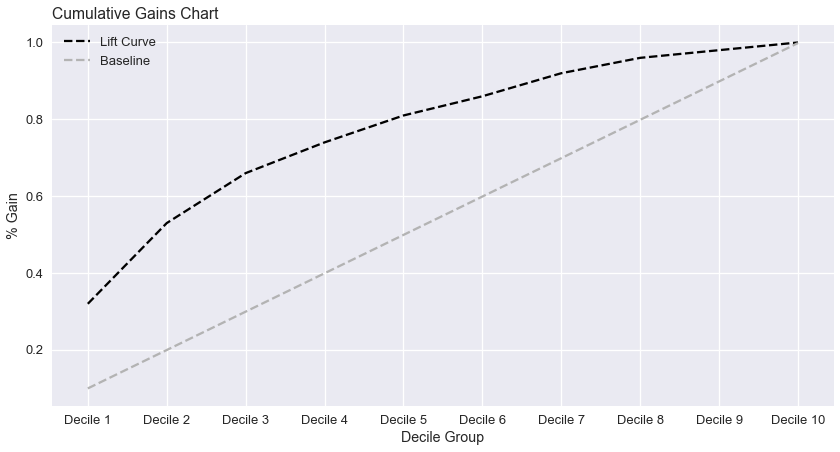

In [1013]:
plt.figure(figsize=(14,7))
x = list(range(1,11))
plt.plot(x,list(lift_table['Cumulative % of All Defaults']),'k--',label='Lift Curve')
plt.plot(x,list(lift_table['Random Expected Defaults'] / sum(test_sorted['default payment next month'])), '--', color=(0.7, 0.7, 0.7), label='Baseline')
my_xticks = ['Decile 1', 'Decile 2', 'Decile 3', 'Decile 4', 'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8', 'Decile 9', 'Decile 10']
plt.title('Cumulative Gains Chart',loc='left')
plt.ylabel('% Gain')
plt.xlabel('Decile Group')
plt.xticks(x,my_xticks)
plt.legend(loc='best')

**Potential Credit Modification Strategy**

Small reductions in the metrics most correlated with client defaults can provide significant relief to borrowers and stave off defaults.  Let's take a look at how we can modify credit based on feature importance above:

- **Bill Amount:** Reduce installment payments to aid monthly cash flow for the client
- **Payment Month:** Reduce limits at early signs of financial stress before customer can use additional availability
- **Age:** With younger clients, we could possibly extend payments until client income increases over time


# Summary

Data analytics and predictive modeling are instrumental in understanding customer behavior in lending and finance, and can serve to improve the bottom line when done so correctly. As with any good data analysis, we started our process by conducting exploratory data analysis which helped us identify features that are most correlated with-high risk clients. Based on this analysis, we found that the three most highly correlated features for high-risk clients are limit balance, payment history, and payment amount. We can infer, from our data exploration, that client cash flow data is important to understanding default risk.  

Having identified features that will potentially be good predictors of default, we were able to construct a predictive model using the XGBoost Classifier algorithm. Our AUC score of 80% indicates that we were able to decisively split high-risk clients from low-risk clients. Moreover, we were able to identify what features are most important to determining defaults in the model. While we were able to create a good prediction model, we could further enhance its performance with better information such as monthly cash flow influx, monthly expenses, investments, occupation and geographical statistics.

Finally, we take the analysis a step further by using our XGBoost Classifier Model to develop an active risk-management strategy aimed at mitigating loss from high risk-clients. Using  Gains / Lift tables, we were able to develop a plan which efficiently targets high-risk clients for modification initiatives. In doing so, we could possibly save the benefactor money by 1) minimizing the loss from defaults and 2) efficiently using company resources to reach high-risk clients. Moreover, with regard to processing credit modifications, we learned that we could leverage feature importance identified by the classifier to refine the variables most damaging to a client's financial health.

I really enjoyed going through this analysis with you. Please feel free to reach out to me with any questions.


**Sources**
- *Jain, Aarshay. “Complete Guide to Parameter Tuning in XGBoost (with codes in Python).” Analytics Vidhya. March 2016. Accessed: July 2017.
- **Zehori, Ido. “Credit Score.” Kaggle.com. August 2016. Accessed: July 2017.